In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV

In [2]:
DATADIR = r"D:\D-Drive\Desktop\Cd rive All with project\MS-projects\Hindko Spoken Digits\data_distribution\data_distribution8-30\train"
CATEGORIES = ['0', '1','2','3','4','5','6','7','8','9']
IMG_SIZE=28

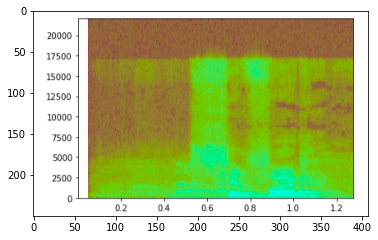

In [3]:
for category in CATEGORIES:
    path=os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        plt.imshow(img_array)
        plt.show()
        break
    break

In [4]:
training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data() 

In [5]:
print(len(training_data))

930


In [6]:
lenofimage = len(training_data)

In [7]:
X=[]
y=[]

for categories, label in training_data:
    X.append(categories)
    y.append(label)
X= np.array(X).reshape(lenofimage,-1)
##X = tf.keras.utils.normalize(X, axis = 1)

In [8]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols)

In [9]:
X = X.reshape(X.shape[0], img_rows, img_cols,3)

In [10]:
X.shape

(930, 28, 28, 3)

In [11]:
X = X/255.0

In [12]:
y=np.array(y)

In [13]:
y.shape

(930,)

In [14]:
SEED = 42
from sklearn.model_selection import train_test_split
import random
random.seed(SEED)
# partition the data into 80% training and 20% validation
(trainX, testX, trainY, testY) = train_test_split(X,y, test_size=0.4, random_state=SEED)

In [15]:
import time   # time1 = time.time(); print('Time taken: {:.1f} seconds'.format(time.time() - time1))
import warnings
warnings.filterwarnings("ignore")
from keras.optimizers import SGD

In [16]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)   # fit_transform = find all unique class labels + transform into one-hot encoded labels
testY = lb.transform(testY)         # transform = perform the one-hot encoding (unique class labels already found)

In [17]:
testY

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [18]:
def create_model(num_classes):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes,activation = 'sigmoid')
    ])
    return model


In [19]:
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout': [0.2, 0.3, 0.4]
}


In [20]:
#model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)

#grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
#grid_result = grid.fit(trainX, trainY)

#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [21]:
import tensorflow as tf
optimizer = tf.keras.optimizers.legacy.Adam(lr=0.001, epsilon=1e-08, decay=0.01)
import keras.backend as K
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def conditional_average_metric(y_true, y_pred):
    spec = specificity(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)

    minimum = K.minimum(spec, sens)
    condition = K.less(minimum, 0.5)

    multiplier = 0.001
    # This is the constant used to substantially lower
    # the final value of the metric and it can be set to any value
    # but it is recommended to be much lower than 0.5

    result_greater = 0.5 * (spec + sens)
    result_lower = multiplier * (spec + sens)
    result = K.switch(condition, result_lower, result_greater)

    return result
def sensitivity(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
metrics=[tf.keras.metrics.AUC(num_thresholds=200,curve='ROC',summation_method='interpolation',name=None,dtype=None,thresholds=None,multi_label=False,num_labels=None,label_weights=None,from_logits=False),
                         tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
                   specificity,conditional_average_metric ,sensitivity,F1_Score,'accuracy']

In [22]:
# initialize our initial learning rate and # of epochs to train for
INIT_LR = 0.01
EPOCHS = 120
 
# compile the model using SGD as our optimizer and categorical cross-entropy loss
# (you'll want to use binary_crossentropy for 2-class classification)
print("[INFO] training network...")
opt = SGD(lr=INIT_LR)   # Stochastic Gradient Descent (SGD) optimizer
model = create_model(10)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=metrics)

[INFO] training network...


In [23]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

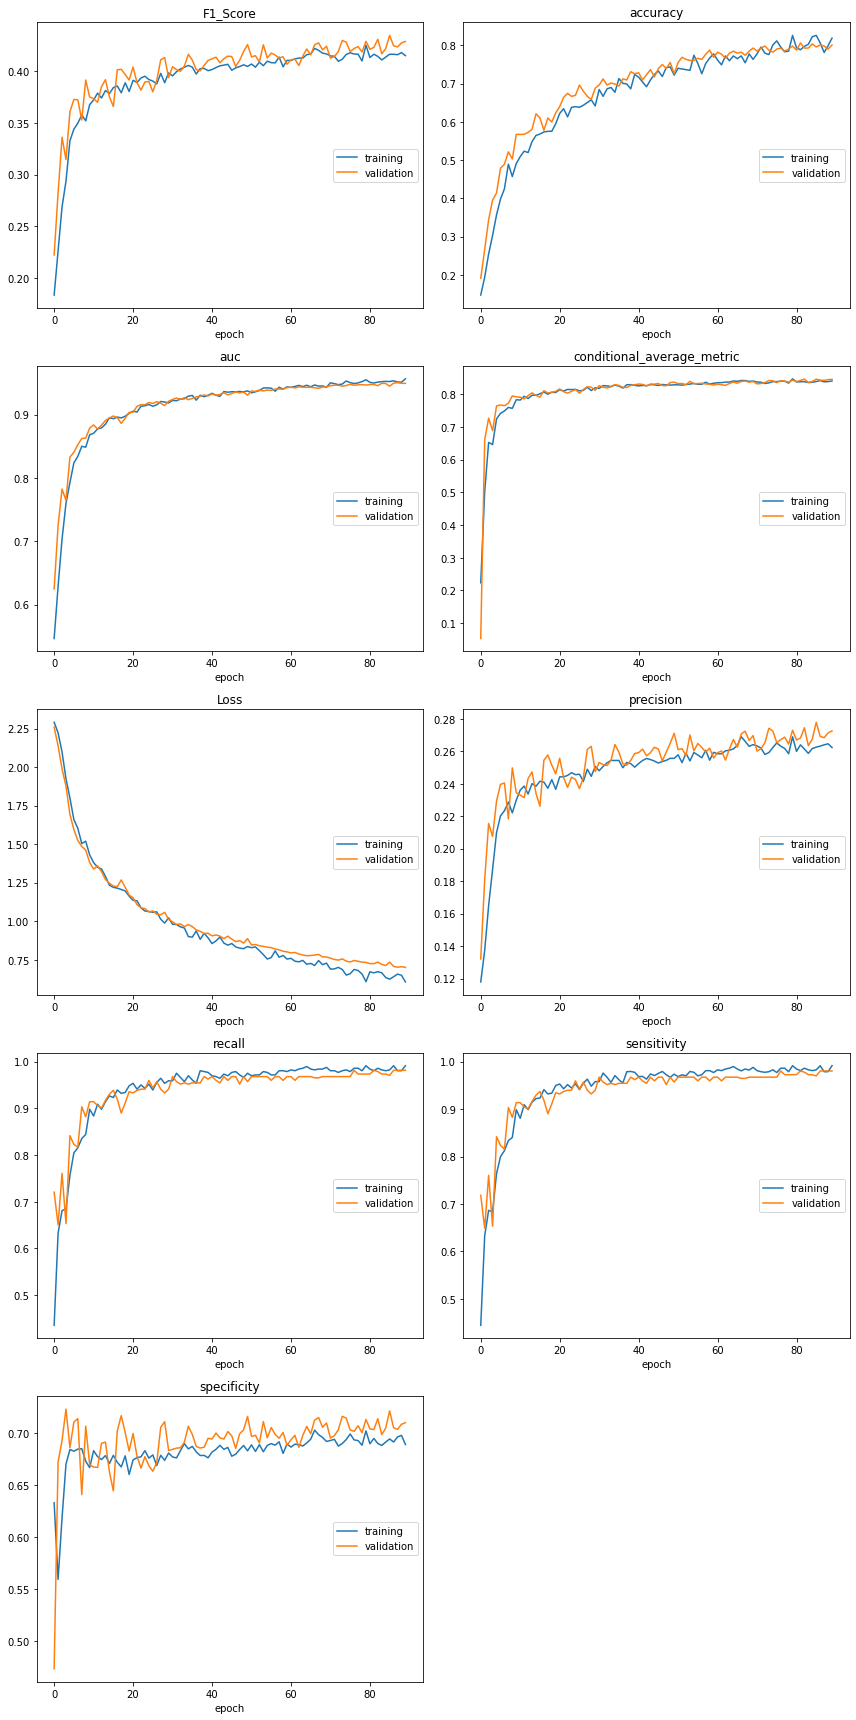

F1_Score
	training         	 (min:    0.184, max:    0.425, cur:    0.415)
	validation       	 (min:    0.223, max:    0.434, cur:    0.428)
accuracy
	training         	 (min:    0.147, max:    0.826, cur:    0.819)
	validation       	 (min:    0.191, max:    0.806, cur:    0.801)
auc
	training         	 (min:    0.546, max:    0.956, cur:    0.956)
	validation       	 (min:    0.625, max:    0.950, cur:    0.949)
conditional_average_metric
	training         	 (min:    0.223, max:    0.847, cur:    0.840)
	validation       	 (min:    0.053, max:    0.846, cur:    0.845)
Loss
	training         	 (min:    0.606, max:    2.291, cur:    0.606)
	validation       	 (min:    0.700, max:    2.259, cur:    0.700)
precision
	training         	 (min:    0.118, max:    0.269, cur:    0.262)
	validation       	 (min:    0.132, max:    0.278, cur:    0.273)
recall
	training         	 (min:    0.435, max:    0.991, cur:    0.991)
	validation       	 (min:    0.651, max:    0.981, cur:    0.981)
sensi

In [24]:
# train the neural network on training data set
# batch_size (32) controls the size of each group of data to pass through the network. 
# Larger GPUs would be able to accommodate larger batch sizes (eg. 64)
time1 = time.time()   # to measure time taken
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=90, batch_size=32,callbacks = [plot_loss_1])
print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # to measure time taken

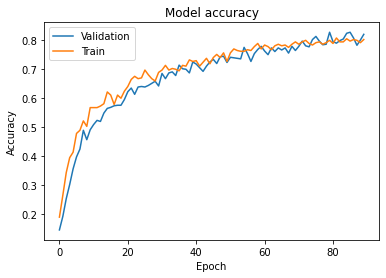

In [25]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')
plt.show()

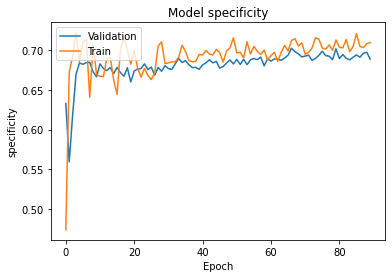

In [26]:
plt.plot(H.history['specificity'])
plt.plot(H.history['val_specificity'])
plt.title('Model specificity')
plt.ylabel('specificity')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')
plt.show()

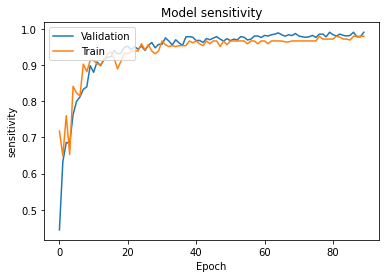

In [27]:
plt.plot(H.history['sensitivity'])
plt.plot(H.history['val_sensitivity'])
plt.title('Model sensitivity')
plt.ylabel('sensitivity')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')
plt.show()

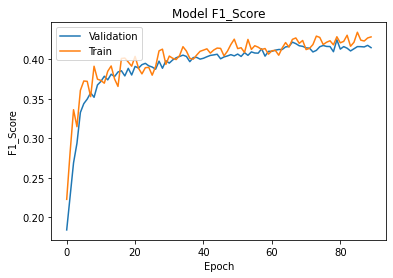

In [28]:
plt.plot(H.history['F1_Score'])
plt.plot(H.history['val_F1_Score'])
plt.title('Model F1_Score')
plt.ylabel('F1_Score')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')
plt.show()

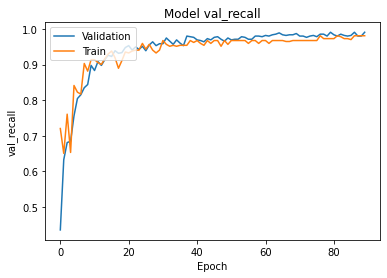

In [29]:
plt.plot(H.history['recall'])
plt.plot(H.history['val_recall'])
plt.title('Model val_recall')
plt.ylabel('val_recall')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')
plt.show()

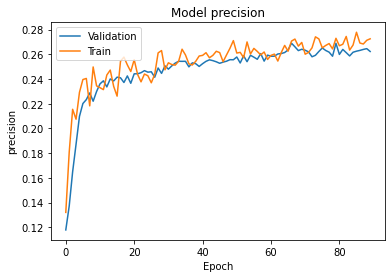

In [30]:
plt.plot(H.history['precision'])
plt.plot(H.history['val_precision'])
plt.title('Model precision')
plt.ylabel('precision')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')
plt.show()

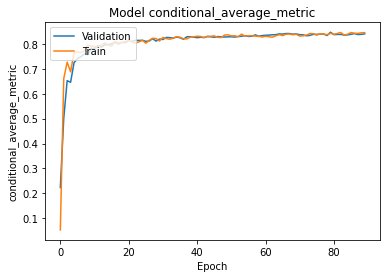

In [31]:
plt.plot(H.history['conditional_average_metric'])
plt.plot(H.history['val_conditional_average_metric'])
plt.title('Model conditional_average_metric')
plt.ylabel('conditional_average_metric')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')
plt.show()

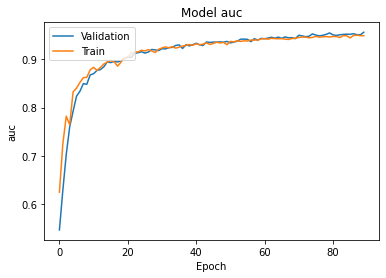

In [32]:
plt.plot(H.history['auc'])
plt.plot(H.history['val_auc'])
plt.title('Model auc')
plt.ylabel('auc')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')
plt.show()

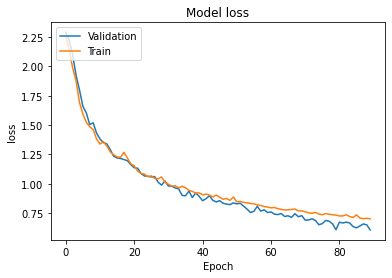

In [33]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')
plt.show()

In [34]:
y2 = model.predict(testX)
print(y2)

12/12 [==============================] - 1s 17ms/step
[[9.9085367e-01 4.6488594e-02 2.3743078e-04 ... 9.9773705e-01
  2.4030080e-02 9.6084377e-06]
 [1.4136676e-02 7.9100013e-01 7.1543947e-02 ... 5.8890685e-02
  1.7650971e-01 9.4261840e-02]
 [9.6232599e-01 1.7262901e-01 4.5060705e-02 ... 1.9623731e-01
  5.3004637e-02 3.1084467e-03]
 ...
 [6.3590240e-01 2.9624369e-02 3.8649749e-03 ... 9.8331547e-01
  2.5361134e-02 2.2476864e-04]
 [6.8510801e-04 6.8924212e-01 9.8258322e-01 ... 2.3453264e-04
  4.3877825e-01 6.4282733e-01]
 [9.2359856e-02 9.7249240e-01 4.6679273e-01 ... 8.4419297e-03
  5.7252735e-01 6.0022660e-02]]


In [35]:
# evaluate the network
from sklearn.metrics import classification_report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=CATEGORIES))

[INFO] evaluating network...
12/12 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       0.69      0.81      0.75        47
           2       0.85      0.82      0.84        40
           3       0.83      0.59      0.69        41
           4       0.78      0.79      0.78        39
           5       0.63      0.59      0.61        37
           6       0.93      0.95      0.94        41
           7       1.00      1.00      1.00        28
           8       0.48      0.61      0.54        18
           9       0.74      0.74      0.74        34

    accuracy                           0.80       372
   macro avg       0.79      0.79      0.79       372
weighted avg       0.81      0.80      0.80       372



In [36]:
testY

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [37]:
y_pred=np.argmax(y2, axis=1)
y_test=np.argmax(testY, axis=1)

In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[47,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 38,  0,  0,  0,  5,  0,  0,  4,  0],
       [ 0,  3, 33,  0,  0,  0,  0,  0,  1,  3],
       [ 0,  8,  0, 24,  4,  1,  0,  0,  4,  0],
       [ 0,  2,  0,  0, 31,  0,  3,  0,  0,  3],
       [ 0,  2,  1,  4,  4, 22,  0,  0,  2,  2],
       [ 0,  0,  0,  0,  1,  1, 39,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 28,  0,  0],
       [ 0,  0,  0,  0,  0,  6,  0,  0, 11,  1],
       [ 0,  2,  5,  1,  0,  0,  0,  0,  1, 25]], dtype=int64)

<AxesSubplot:>

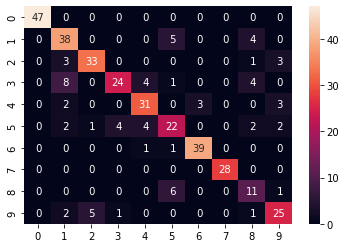

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='2.0f')

In [40]:
from sklearn.metrics import accuracy_score
print("Accuracy on unknown data is",accuracy_score(y_test,y_pred)*100,"on 100 epochs")

Accuracy on unknown data is 80.10752688172043 on 100 epochs
